# 1. Linear SVM and Cost Parameter Effect

In [1]:
from pathlib import Path
import pandas as pd

path = Path("/Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Hitters.csv")
if not path.exists():
    raise FileNotFoundError(f"File not found: {path}")

hitters = pd.read_csv(path)
print("Loaded:", path)
print("Shape:", hitters.shape)
hitters.head()

Loaded: /Users/anhnguyen/Documents/GitHub/2025AAE722_AnhNguyen/2025 AAE722 Anh Nguyen Submission/ALL CSV FILES - 2nd Edition/Hitters.csv
Shape: (322, 20)


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [5]:
# drop rows with missing Salary and create binary response 'High'
hitters_clean = hitters.dropna(subset=['Salary']).reset_index(drop=True)

median_salary = hitters_clean['Salary'].median()
hitters_clean['High'] = (hitters_clean['Salary'] > median_salary).astype(int)

print(f"Rows before: {hitters.shape[0]}, after: {hitters_clean.shape[0]}")
print("Median Salary:", median_salary)
print(hitters_clean['High'].value_counts())

Rows before: 322, after: 263
Median Salary: 425.0
High
0    134
1    129
Name: count, dtype: int64


C = 0.1: # support vectors = 128
C = 100: # support vectors = 128


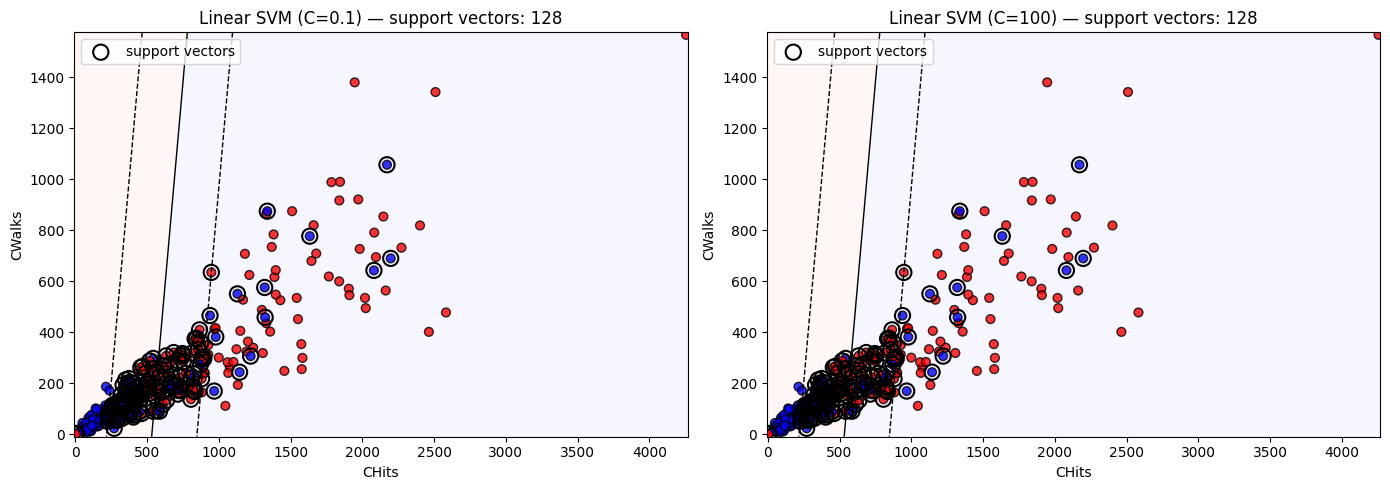

In [6]:
import numpy as np
from sklearn.svm import SVC

import matplotlib.pyplot as plt

# Use CHits and CWalks as features and High as target (already present in notebook)
X = hitters_clean[['CHits', 'CWalks']].values
y = hitters_clean['High'].values

# Fit two linear SVMs with different C
models = {
    0.1: SVC(kernel='linear', C=0.1),
    100: SVC(kernel='linear', C=100),
}
for C, mdl in models.items():
    mdl.fit(X, y)

# Report number of support vectors
for C, mdl in models.items():
    print(f"C = {C}: # support vectors = {len(mdl.support_)}")

# Helper to plot decision boundary, margins, points and support vectors
def plot_svm(ax, model, X, y, title=None):
    x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
    y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                         np.linspace(y_min, y_max, 500))
    Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # decision region shading
    ax.contourf(xx, yy, Z, levels=[Z.min(), 0, Z.max()], alpha=0.1, colors=['#FFAAAA', '#AAAAFF'])
    # decision boundary and margins
    ax.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k', linewidths=1)
    # points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', s=40, alpha=0.8)
    # support vectors
    sv = model.support_vectors_
    ax.scatter(sv[:, 0], sv[:, 1], facecolors='none', edgecolors='k', s=120, linewidths=1.5, label='support vectors')
    ax.set_xlabel('CHits')
    ax.set_ylabel('CWalks')
    if title:
        ax.set_title(title)
    ax.legend(loc='upper left')

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
for ax, (C, mdl) in zip(axes, models.items()):
    plot_svm(ax, mdl, X, y, title=f"Linear SVM (C={C}) — support vectors: {len(mdl.support_)}")
plt.tight_layout()
plt.show()

Increasing C reduces regularization so the SVM penalizes misclassification more, which typically yields a narrower margin.

A larger C makes the model more flexible (higher variance) and fits the training data more closely, whereas a smaller C enforces a wider margin and stronger regularization (simpler model).

Small C often results in more points lying within or on the margin (more support vectors), while large C usually leaves fewer support vectors, though the exact count depends on the data.

# 2. Hyperparameter Tuning with Cross-Validation

Best C: 0.01
Best CV accuracy: 0.8060957910014513
All mean CV scores (C -> mean accuracy):
  0.01 -> 0.8061
  0.1 -> 0.8061
  1 -> 0.8061
  10 -> 0.8061
  100 -> 0.8061


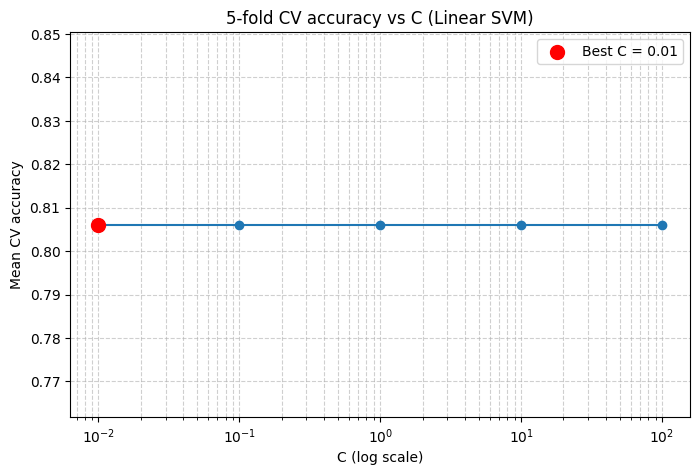

In [9]:
#stop warning 
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")


from sklearn.model_selection import GridSearchCV

Cs = [0.01, 0.1, 1, 10, 100]
grid = GridSearchCV(SVC(kernel='linear'), param_grid={'C': Cs}, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)

best_C = grid.best_params_['C']
best_score = grid.best_score_
mean_scores = grid.cv_results_['mean_test_score']

print("Best C:", best_C)
print("Best CV accuracy:", best_score)
print("All mean CV scores (C -> mean accuracy):")
for c, s in zip(Cs, mean_scores):
    print(f"  {c} -> {s:.4f}")

# Plot CV accuracy vs C on log-scale x-axis and mark best C
plt.figure(figsize=(8, 5))
plt.plot(Cs, mean_scores, marker='o', linestyle='-')
plt.xscale('log')
plt.xlabel('C (log scale)')
plt.ylabel('Mean CV accuracy')
plt.title('5-fold CV accuracy vs C (Linear SVM)')
plt.scatter([best_C], [best_score], color='red', s=100, zorder=5, label=f'Best C = {best_C}')
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.6)
plt.show()

# 3. RBF Kernel and Model Comparison 

Train accuracy: 0.97
Test accuracy:  0.99
Support vectors per class: [19 31]


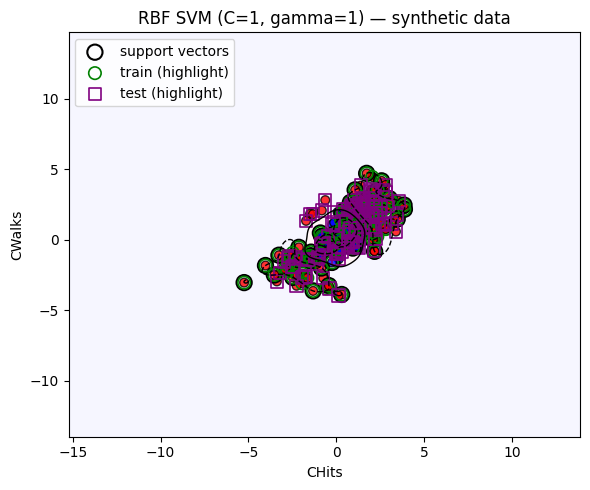

In [14]:
from sklearn.metrics import accuracy_score

# generate synthetic data (use your code) and create a non-linear (circular) class boundary
np.random.seed(42)
X = np.random.randn(200, 2)
X[:100] += 2
X[100:150] -= 2
# create a non-linear label: outer points vs inner points (circular decision boundary)
y = (X[:, 0]**2 + X[:, 1]**2 > 4).astype(int)  # 0 = inside circle, 1 = outside

# split 50/50
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.5, stratify=y, random_state=42)

# fit RBF SVM (C=1, gamma=1)
mdl_rbf = SVC(kernel='rbf', C=1, gamma=1)
mdl_rbf.fit(X_tr, y_tr)

print("Train accuracy:", accuracy_score(y_tr, mdl_rbf.predict(X_tr)))
print("Test accuracy: ", accuracy_score(y_te, mdl_rbf.predict(X_te)))
print("Support vectors per class:", mdl_rbf.n_support_)

# visualize decision boundary using plot_svm (from earlier cell)
fig, ax = plt.subplots(figsize=(6, 5))
plot_svm(ax, mdl_rbf, X, y, title='RBF SVM (C=1, gamma=1) — synthetic data')

# highlight train/test splits on top of the plot
ax.scatter(X_tr[:, 0], X_tr[:, 1], facecolors='none', edgecolors='green', s=80, linewidths=1.2, label='train (highlight)')
ax.scatter(X_te[:, 0], X_te[:, 1], facecolors='none', edgecolors='purple', marker='s', s=80, linewidths=1.2, label='test (highlight)')

ax.legend(loc='upper left')
plt.tight_layout()
plt.show()


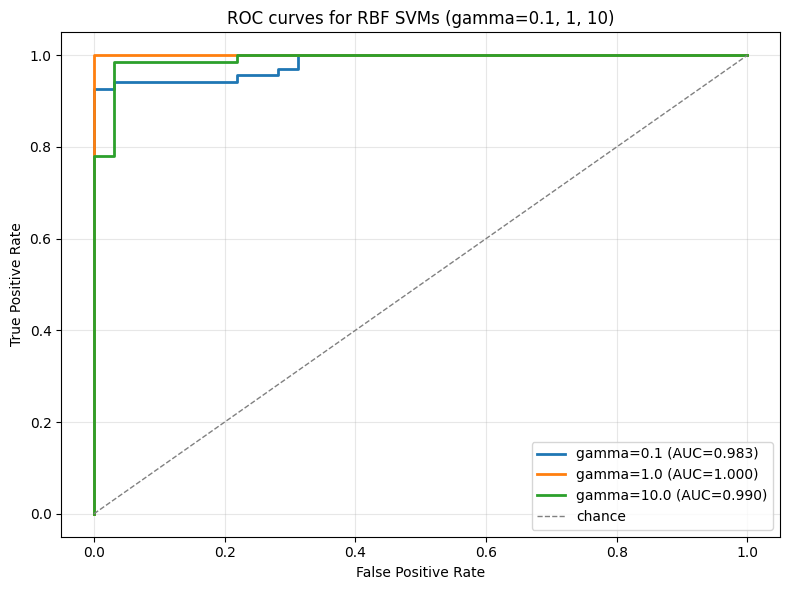

Best performing gamma: 1.0 with AUC = 1.000.
Higher gamma makes the RBF kernel narrower and the model more complex (can overfit); lower gamma yields a smoother, simpler decision boundary (can underfit).


In [13]:
from sklearn.metrics import roc_curve, auc

# fit two additional RBF SVMs (gamma 0.1 and 10). mdl_rbf (gamma=1) is already fitted in the notebook.
mdl_g01 = SVC(kernel='rbf', C=1, gamma=0.1)
mdl_g10 = SVC(kernel='rbf', C=1, gamma=10)
mdl_g01.fit(X_tr, y_tr)
mdl_g10.fit(X_tr, y_tr)

# collect models and labels
models = {
    0.1: mdl_g01,
    1.0: mdl_rbf,
    10.0: mdl_g10,
}

plt.figure(figsize=(8, 6))
best_gamma = None
best_auc = -1.0

for gamma, model in models.items():
    scores = model.decision_function(X_te)
    fpr, tpr, _ = roc_curve(y_te, scores)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'gamma={gamma} (AUC={roc_auc:.3f})')
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_gamma = gamma

# plot random-chance line
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--', label='chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves for RBF SVMs (gamma=0.1, 1, 10)')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# short programmatic explanation (2-3 sentences)
print(f"Best performing gamma: {best_gamma} with AUC = {best_auc:.3f}.")
print("Higher gamma makes the RBF kernel narrower and the model more complex (can overfit); lower gamma yields a smoother, simpler decision boundary (can underfit).")